In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd "gdrive/My Drive"
!pwd

/content/gdrive/My Drive
/content/gdrive/My Drive


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Assuming CUDA is available on your machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
df = pd.read_csv("participant_transcript_data.csv")
transcripts = df['Transcript'].tolist()
labels = df['PHQ8_Binary'].tolist()

# Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(transcripts, labels, test_size=.4)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset
class TranscriptDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Hyperparameters
max_len = 128
batch_size = 16

# Create Data Loaders
train_dataset = TranscriptDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = TranscriptDataset(val_texts, val_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # num_labels=1 for binary classification
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Loss Function
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)

# Training loop with loss printing
for epoch in range(5):  # loop over the dataset multiple times
    model.train()
    total_loss = 0  # Initialize total loss for the epoch
    for batch in train_loader:
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device).float().unsqueeze(1)  # Adjust for BCEWithLogitsLoss

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        loss = loss_fn(outputs.logits, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print loss every step
        print(f"Step loss: {loss.item()}")

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1} average loss: {average_loss}')

print('Finished Training')

# Evaluation loop
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits.squeeze()
        preds = torch.round(torch.sigmoid(logits))  # Sigmoid layer to get the prediction

        predictions.extend(preds.tolist())
        true_labels.extend(batch_labels.tolist())

print(classification_report(true_labels, predictions))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step loss: 0.6735479831695557
Step loss: 0.635826587677002
Step loss: 0.7578021287918091
Epoch 1 average loss: 0.6890588998794556
Step loss: 0.7514595985412598
Step loss: 0.6062631607055664
Step loss: 0.6267818808555603
Epoch 2 average loss: 0.6615015467007955
Step loss: 0.7284831404685974
Step loss: 0.5736281871795654
Step loss: 0.6201292276382446
Epoch 3 average loss: 0.6407468517621359
Step loss: 0.6841808557510376
Step loss: 0.6648149490356445
Step loss: 0.5867559313774109
Epoch 4 average loss: 0.6452505787213644
Step loss: 0.7448923587799072
Step loss: 0.6104731559753418
Step loss: 0.49170631170272827
Epoch 5 average loss: 0.6156906088193258
Finished Training
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        16
           1       0.00      0.00      0.00        15

    accuracy                           0.52        31
   macro avg       0.26      0.50      0.34        31
weighted avg       0.27      0.52      0.35        31



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Prediction function for an input transcript
def predict_transcript(transcript):
    inputs = tokenizer(transcript, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    score = logits.softmax(dim=-1)
    prediction = score.argmax(dim=-1).cpu().numpy()[0]
    return prediction

# Example usage:
transcript_text = "33.736	36.456	Ellie	hi i'm ellie thanks for coming in today 37.076	40.306	Ellie	i was created to talk to people in a safe and secure environment 40.976	45.326	Ellie	think of me as a friend i don't judge i can't i'm a computer 46.306	55.786	Ellie	i'm here to learn about people and would love to learn about you i'll ask a few questions to get us started and please feel free to tell me anything your answers are totally confidential 56.766	57.996	Ellie	where are you from originally 59.256	60.676	Participant	los angeles california 61.586	62.036	Ellie	really 62.976	63.376	Participant	yes 63.386	65.346	Ellie	what are some things you really like about l_a 66.406	74.826	Participant	um the southern california lifestyle the beaches the um active lifestyle 75.733	76.233	Ellie	okay 77.753	79.813	Ellie	what are some things you don't really like about l_a 80.025	80.715	Participant	the traffic 81.825	84.145	Participant	the pretentious people 85.935	86.345	Ellie	yeah 88.435	90.775	Ellie	who's someone that's been a positive influence in your life 97.079	98.039	Participant	um 99.079	99.939	Participant	my teachers 101.329	102.019	Participant	um 101.776	102.796	Ellie	tell me more about that 105.686	108.856	Participant	i don't know certain teachers um 110.376	111.226	Participant	got uh 117.056	118.976	Participant	spiritual teachers that i 120.026	120.686	Participant	um 123.466	124.966	Participant	find a lot of guidance from 126.526	127.036	Ellie	mhm 129.316	129.666	Participant	<laughter> 130.815	132.635	Ellie	what are some things you like to do for fun 130.845	131.295	Participant	that's it 133.224	134.524	Participant	mm i like to skateboard 135.644	136.864	Participant	and 136.164	136.724	Ellie	awesome 138.81	140.81	Participant	and just stay active stay healthy 141.53	142.3	Participant	um 143.76	145.27	Participant	anything that's um 146.25	148.36	Participant	outdoors and active and healthy 149.67	152.99	Participant	hiking biking rollerblading skateboarding 154.808	155.748	Participant	all the above 155.278	155.818	Ellie	that's good 158.168	159.168	Ellie	do you travel a lot 159.888	160.588	Participant	mm no 162.068	162.498	Ellie	why 163.798	168.208	Participant	mm not really in a position to travel financially 170.508	171.418	Ellie	i understand 172.678	174.248	Ellie	what do you enjoy about traveling 175.885	180.545	Participant	if i could i'm sure i would enjoy seeing all the different cultures and places and 181.615	188.705	Participant	meeting all the different people and all the interesting structures and uh 190.205	191.825	Participant	the food so 191.979	192.379	Ellie	yeah 193.809	195.249	Ellie	what do you do to relax 195.869	196.579	Participant	i meditate 198.199	199.129	Participant	and i skateboard 200.129	202.109	Participant	well i can meditate on my board 204.379	206.679	Ellie	<laughter> could you say a little more about that 207.515	208.335	Participant	mm 209.555	212.455	Participant	i meditate it helps me relax um 213.585	223.755	Participant	sometimes if i don't really feel like skating hard i'll just go for a nice uh sunset skate and meditate a nice two hour skate just relax 225.555	227.465	Ellie	that sounds like a great situation 228.545	229.625	Ellie	how hard is that 230.662	231.382	Participant	mm 232.856	244.346	Participant	it's not that hard you just gotta get to the skate spots you know i usually like skating um there's some good good spay skate spots in l_a streets in l_a 245.376	245.816	Ellie	mhm 245.486	247.596	Participant	uh the beaches is always good so 248.416	248.996	Participant	uh 248.686	249.296	Ellie	nice 250.745	253.735	Participant	just uh it's really not that hard at all 255.187	255.745	Ellie	okay 257.485	259.555	Ellie	what are some things that make you really mad 261.265	262.515	Participant	<sigh> 273.985	277.625	Participant	the situation with my life right now um  279.305	281.015	Participant	i can't find a fucking job 283.065	285.345	Ellie	it can be tough to find a good job these days 285.809	288.509	Participant	i don't even care about a good job i just need a job 289.869	290.989	Participant	anything that pays 292.359	292.979	Participant	um 297.729	298.899	Participant	just gets gets 301.619	303.209	Participant	just gets hard after awhile 304.219	304.659	Ellie	yeah 306.779	307.839	Ellie	can you tell me about that 309.678	310.368	Participant	i don't 311.261	314.861	Participant	i applied from a anywhere and everywhere 316.101	318.791	Participant	from entry level to management 319.941	322.421	Participant	to anywhere in between and um 325.936	329.396	Participant	i can't find a job i can't get a job so 332.246	335.936	Participant	i'm trying i'm trying i'm trying i'm trying i'm trying i'm trying i'm trying 337.131	337.511	Ellie	yeah 338.471	339.301	Ellie	i'm sorry 340.681	341.661	Participant	it is what it is 343.241	344.331	Ellie	do you feel down 345.541	346.941	Participant	yeah it's pretty depressing 348.121	348.631	Participant	it's hard 349.581	350.231	Participant	sucks 352.321	352.751	Ellie	yeah 355.156	357.356	Ellie	how easy is it for you to get a good night's sleep 358.056	359.936	Participant	mm it isn't 362.076	363.506	Participant	<yawn> it isn't 363.036	364.136	Ellie	do you feel that way often 364.966	367.356	Participant	yes it eh yes that happens often 369.826	371.466	Ellie	when was the last time that happened 372.636	374.306	Participant	uh last night i couldn't sleep 376.056	376.456	Ellie	why 377.446	378.546	Participant	mm 380.296	382.796	Participant	just uh thinking about my situation 384.486	385.566	Participant	um 387.416	389.526	Participant	my car payment was due yesterday 391.126	396.646	Participant	and i just i don't know if i have what it takes to continue to do this 397.679	398.119	Participant	you know 400.449	402.019	Participant	i survive day by day 401.678	402.078	Ellie	mhm 403.499	404.189	Participant	trying to 405.379	406.359	Participant	see if i can eat 408.449	409.489	Participant	at the end of the day 412.149	413.169	Participant	um 412.968	414.828	Ellie	have you been diagnosed with depression 415.478	415.898	Participant	yes 417.758	419.538	Ellie	how long ago were you diagnosed 420.158	420.968	Participant	mm 421.848	422.878	Participant	about three years ago 424.458	425.308	Participant	four years ago 426.268	427.268	Participant	couple years ago 429.248	430.558	Ellie	what got you to seek help 434.318	437.638	Participant	my mood was just not right 439.328	445.098	Participant	i was always feeling down and depressed and <sniffle> lack of energy always wanting to sleep 446.268	448.458	Participant	um lack of interest 452.218	453.558	Ellie	do you feel like therapy is useful 455.176	459.146	Participant	i've gone to therapy it has been useful for me in the past 459.939	463.609	Participant	is it useful for me now i don't know i don't have health insurance 464.709	465.339	Participant	um 468.589	472.399	Participant	i would love to talk to someone i just feel like i don't have anyone 473.689	475.829	Participant	so i don't depend on anyone 477.369	479.079	Ellie	yeah i'm sorry 480.699	482.849	Ellie	did you think you had a problem before you found out 484.379	487.419	Participant	oh yeah i've always felt depressed in my life 488.609	489.899	Ellie	what were your symptoms 490.936	491.576	Participant	mm 492.715	493.635	Participant	lack of energy 494.725	496.015	Participant	wanting to sleep a lot 497.075	498.385	Participant	lack of interest 501.235	509.815	Participant	my appetite was uncontrollable either lack of or i was just being gluttonous and eating the wrong things 513.815	516.985	Ellie	have you noticed any changes in your behavior or thoughts lately 518.045	518.655	Participant	yes 521.055	522.345	Ellie	can you give me an example of that 525.325	527.205	Participant	my sister just passed away 528.975	530.085	Ellie	i'm sorry to hear that 530.181	532.465	Participant	it's alright six months ago 534.075	535.295	Participant	and i became 536.655	538.925	Participant	homeless and jobless two weeks ago 540.926	542.706	Participant	and it got to a point where 544.036	546.156	Participant	i just missed her and i wanted to be with her 547.976	548.436	Ellie	yeah 549.436	549.916	Participant	so 555.876	557.616	Ellie	how close are you to your family 559.352	560.012	Participant	mm 562.532	564.302	Participant	pretty dysfunctional family 566.992	569.762	Participant	you know really can't depend on them 571.202	574.372	Participant	that's why i just depend on myself <sigh> so 575.872	577.242	Ellie	that sounds really hard 578.352	580.142	Participant	it is what it is what are you gonna do 581.442	581.922	Ellie	yeah 584.088	585.418	Participant	i'd like to give up but 588.438	594.268	Participant	my parents just buried their daughter six months ago they don't wanna bury their other daughter 595.878	596.308	Participant	so 598.678	601.528	Ellie	what advice would you give yourself ten or twenty years ago 606.778	607.908	Participant	<sigh> 614.456	615.186	Participant	i don't know  617.606	619.166	Participant	i don't know just uh 620.526	622.026	Participant	i just haven't had good luck 623.706	625.786	Participant	i was a corporate manager for twenty years 627.526	628.416	Participant	and uh 634.046	638.006	Participant	who would've known twenty years ago what advice i would've given myself because 639.226	644.036	Participant	i tried to commit suicide instead of returning back to work 646.066	651.466	Participant	and so now it's just uh it's been rough trying to pick up all the pieces and 646.866	647.256	Ellie	hmm 652.706	654.116	Participant	get my life back together 655.186	655.811	Participant	um 657.381	659.401	Participant	i don't know what advice i would give myself 661.041	665.261	Participant	when i started with my corporate job twenty years ago 667.501	667.941	Ellie	okay 667.501	670.881	Participant	because i didn't know i'd be here twenty years later 672.631	673.181	Participant	you know 675.431	675.861	Ellie	yeah 677.831	680.321	Ellie	when was the last time you felt really happy 687.881	688.921	Participant	really happy 691.33	692.26	Participant	um 694.83	696.94	Participant	a couple days ago this week 698.45	701.54	Participant	<sigh> i've been trying to make ends meet 702.59	704.56	Participant	i've got a lot of things sprouting 705.45	706.89	Participant	i've got a lot of things 709.17	714.62	Participant	that are happening for me but i need like two more weeks here in l_a 715.79	717.46	Participant	so i can connect the dots but 718.48	722.16	Participant	financially i don't have what it takes to stay here for two more weeks 723.41	724.05	Participant	so 725.19	728.738	Participant	i was happy because i was getting call backs and 730.458	740.078	Participant	um <sigh> things were starting to look up for me but it's just um time again isn't on my side so my car is packed and i'm hitting the road 741.098	744.078	Participant	and i'm taking off and i'm leaving l_a so 745.848	746.228	Ellie	hmm 748.138	749.778	Ellie	how would your best friend describe you 752.232	753.292	Participant	uh loyal 754.872	755.632	Participant	emotional 758.662	759.442	Participant	strong 766.132	766.762	Participant	that's it 767.996	769.596	Ellie	do you consider yourself an introvert 771.471	772.441	Participant	um 773.231	774.361	Participant	i have been lately 776.041	778.981	Participant	um i was an extrovert for 780.031	782.221	Participant	twenty years when i was a corporate manager 783.181	787.591	Participant	and now i am quite an introvert and i stick to myself 790.061	791.541	Ellie	what made you decide to do that 792.363	795.513	Participant	uh circumstances in my life i don't feel as confident 797.403	798.853	Participant	i don't feel 800.563	802.573	Participant	as uh charming 804.313	805.823	Participant	and as social 808.473	808.903	Ellie	okay 810.053	812.313	Ellie	what's one of your most memorable experiences 816.133	816.963	Participant	mm 819.893	820.613	Participant	i don't know 821.353	822.163	Participant	it's hard to say 824.193	825.373	Participant	can't really answer that one 828.673	829.083	Ellie	okay 831.523	833.823	Ellie	okay i think i've asked everything i need to 835.133	836.683	Ellie	thanks for sharing your thoughts with me 836.893	837.393	Participant	thank you 838.293	838.843	Ellie	goodbye 839.093	839.473	Participant	bye"
predicted_score = predict_transcript(transcript_text)
print(f'The predicted PHQ8_Binary score is: {predicted_score}')


The predicted PHQ8_Binary score is: 0


##Using patient text

In [ ]:
!pip install pandas nltk

In [ ]:
import pandas as pd
import re

# Load the data
df = pd.read_csv("participant_transcript_data.csv")

# Function to extract participant text
def extract_participant_text(text):
    participant_speech = []
    # Split the transcript by the speaker labels
    parts = text.split('\t')
    # Iterate over the parts and extract the text that follows 'Participant'
    for i in range(len(parts)):
        if 'Participant' in parts[i]:
            # The actual text is the next element after 'Participant', remove timestamp
            speech = parts[i+1]
            # Remove timestamps and any trailing numbers
            speech = re.sub(r'\d+\.\d+', '', speech).strip()
            participant_speech.append(speech)
    # Join all participant parts into a single string
    return ' '.join(participant_speech)

# Apply the function to create a new column
df['Participant_Text'] = df['Transcript'].apply(extract_participant_text)

# Save the new dataframe to a new CSV file
df.to_csv("participant_transcript_data_with_participant_column.csv", index=False)

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# If you haven't downloaded the NLTK tokenizers before, you may need to do so
nltk.download('punkt')

# Load the dataset
df = pd.read_csv("participant_transcript_data_with_participant_column.csv")

# Ensure the 'Transcript' column is a string
df['Participant_Text'] = df['Participant_Text'].astype(str)

# Tokenize the transcripts
df['Tokenized_Transcript'] = df['Participant_Text'].apply(nltk.word_tokenize)

# Check the dataframe
print(df.head())

# If you want to work with the tokenized data
tokenized_sentences = df['Tokenized_Transcript'].tolist()
ptext = df['Participant_Text'].tolist()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


   Participant_ID  PHQ8_Binary  \
0           300.0          0.0   
1           301.0          0.0   
2           302.0          0.0   
3           303.0          0.0   
4           304.0          0.0   

                                          Transcript  \
0  36.588\t39.668\tEllie\thi i'm ellie thanks for...   
1  29.428\t35.888\tEllie\thi i'm ellie thanks for...   
2  35.18\t37.99\tEllie\thi i'm ellie thanks for c...   
3  26.276\t48.696\tEllie\thi i'm ellie thanks for...   
4  34.01\t45.81\tEllie\thi i'm ellie thanks for c...   

                                    Participant_Text  \
0  good atlanta georgia um my parents are from he...   
1  thank you mmm k i'm doing good thank you i'm f...   
2  i'm fine how about yourself i'm from los angel...   
3  okay how 'bout yourself here in california yea...   
4  i'm doing good um from los angeles california ...   

                                Tokenized_Transcript  
0  [good, atlanta, georgia, um, my, parents, are,...  
1  [thank, 

##Word Cloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


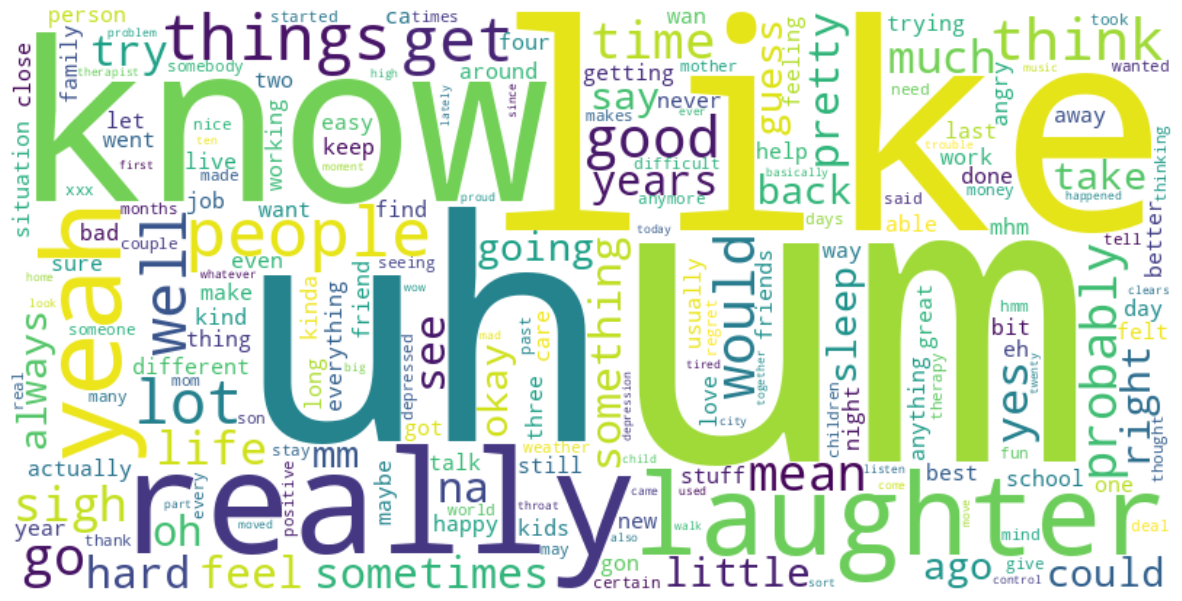

In [ ]:
# Install necessary libraries
!pip install wordcloud

# Import libraries
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# You may need to download the set of stopwords from NLTK if you haven't already
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset (Make sure you have uploaded the dataset to your Colab environment)
df = pd.read_csv("participant_transcript_data_with_participant_column.csv")

# Filter the dataset to include only transcripts with PHQ8_Binary value 1
depression_transcripts = df[df['PHQ8_Binary'] == 1]['Participant_Text'].tolist()

# Combine all transcripts into one large string
combined_transcripts = " ".join(depression_transcripts)

# Tokenize the text
tokens = word_tokenize(combined_transcripts)

# Convert to lower case
tokens = [word.lower() for word in tokens]

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

# Word frequencies
word_freq = Counter(tokens)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)

# Plot the Word Cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
ptext[0]

"good atlanta georgia um my parents are from here um i love it i like the weather i like the opportunities um yes um it took a minute somewhat easy congestion that's it um i took up business and administration uh yeah i am here and there i'm on a break right now but i plan on going back in the uh next semester uh probably to open up my own business no um no specific reason i just don't travel a lot i'm pretty local once a year can you be a little bit more specific no answer i like reading books i enjoy i enjoy cooking um exercising is great i'm i'm i'm pretty good at it um yeah um probably about two weeks ago uh frustrated um i don't like bias um i don't like um when someone says they're gonna do something and they don't uh somewhat friendship i like to play sports i enjoy uh going out with friends and family playing games grandparents parents um yeah i mean they've always given me great advice they've always kept it real real close i would say going to college right after high school 

## t-SNE (t-Distributed Stochastic Neighbor Embedding)

In [ ]:
!pip install gensim

Number of samples:  21
Using perplexity value:  20


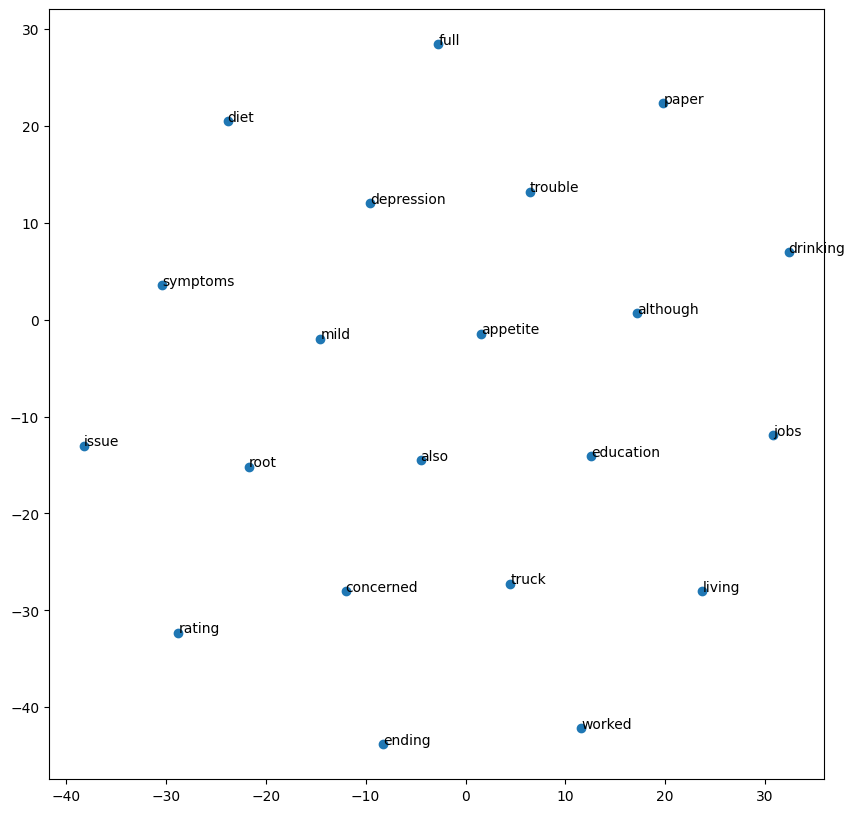

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# Example: Load your dataset here, tokenize and create your corpus
# For this example, let's assume you have a list of sentences called 'tokenized_sentences'

# train model
model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)
model.train(tokenized_sentences, total_examples=len(tokenized_sentences), epochs=10)

# get words close to 'depression'
words = ['depression']
words += [w[0] for w in model.wv.most_similar('depression', topn=20)]

# extract their vectors
word_vectors = np.array([model.wv[w] for w in words])

# Make sure the number of samples is greater than the perplexity
num_samples = len(word_vectors)
print("Number of samples: ", num_samples)

# Choose a perplexity value less than the number of samples
perplexity_value = min(30, num_samples - 1)  # 30 is a common default value for perplexity
print("Using perplexity value: ", perplexity_value)

tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity_value)
word_vectors_2d = tsne.fit_transform(word_vectors)

# # reduce dimensions to 2 using t-SNE
# tsne = TSNE(n_components=2, random_state=0)
# word_vectors_2d = tsne.fit_transform(word_vectors)

# plot the points
plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_2d[:,0], word_vectors_2d[:,1])

# annotate the points on graph
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.show()


In [ ]:
word_vectors

array([[-0.20137948,  0.3374257 , -0.14632909, ..., -0.06180201,
         0.11951755, -0.3058043 ],
       [-0.18160708,  0.26762286,  0.21360992, ..., -0.06056112,
         0.176959  , -0.13540147],
       [-0.12581594,  0.24571542,  0.1538674 , ..., -0.14374071,
         0.13609627, -0.15079436],
       ...,
       [-0.0328173 ,  0.05435608,  0.0446636 , ..., -0.03697446,
         0.06235026, -0.03226629],
       [-0.02529087,  0.04949844,  0.02036396, ..., -0.02772   ,
         0.03455519, -0.02923661],
       [-0.05079593,  0.09498795,  0.05099267, ...,  0.01465519,
         0.03425637, -0.13006675]], dtype=float32)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Assuming CUDA is available on your machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
df = pd.read_csv("participant_transcript_data_with_participant_column.csv")
transcripts = df['Participant_Text'].tolist()
labels = df['PHQ8_Binary'].tolist()

# Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(transcripts, labels, test_size=.2)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset
class TranscriptDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Hyperparameters
max_len = 128
batch_size = 16

# Create Data Loaders
train_dataset = TranscriptDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = TranscriptDataset(val_texts, val_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # num_labels=1 for binary classification
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Loss Function
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)

# Training loop with loss printing
for epoch in range(5):  # loop over the dataset multiple times
    model.train()
    total_loss = 0  # Initialize total loss for the epoch
    for batch in train_loader:
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device).float().unsqueeze(1)  # Adjust for BCEWithLogitsLoss

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        loss = loss_fn(outputs.logits, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print loss every step
        print(f"Step loss: {loss.item()}")

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1} average loss: {average_loss}')

print('Finished Training')

# Evaluation loop
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits.squeeze()
        preds = torch.round(torch.sigmoid(logits))  # Sigmoid layer to get the prediction

        predictions.extend(preds.tolist())
        true_labels.extend(batch_labels.tolist())

print(classification_report(true_labels, predictions))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step loss: 0.6631893515586853
Step loss: 0.7009716033935547
Step loss: 0.7289559841156006
Step loss: 0.6785086989402771
Epoch 1 average loss: 0.6929064095020294
Step loss: 0.7358125448226929
Step loss: 0.6815157532691956
Step loss: 0.7241503596305847
Step loss: 0.6572422981262207
Epoch 2 average loss: 0.6996802389621735
Step loss: 0.629837691783905
Step loss: 0.6741820573806763
Step loss: 0.7058783173561096
Step loss: 0.6396389007568359
Epoch 3 average loss: 0.6623842418193817
Step loss: 0.646034300327301
Step loss: 0.6863769888877869
Step loss: 0.7138820290565491
Step loss: 0.5475042462348938
Epoch 4 average loss: 0.6484493911266327
Step loss: 0.5304198265075684
Step loss: 0.7160546779632568
Step loss: 0.6156359910964966
Step loss: 0.5722785592079163
Epoch 5 average loss: 0.6085972636938095
Finished Training
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.00      0.00      0.00         6

    accuracy   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Prediction function for an input transcript
def predict_transcript(transcript):
    inputs = tokenizer(transcript, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    score = logits.softmax(dim=-1)
    prediction = score.argmax(dim=-1).cpu().numpy()[0]
    return prediction

# # Example usage:
# for i in range(77):
#   predicted_score = predict_transcript(ptext[i])
#   print(f'The predicted PHQ8_Binary score is: {predicted_score}')
predicted_score = predict_transcript(ptext[0])
print(f'The predicted PHQ8_Binary score is: {predicted_score}')

The predicted PHQ8_Binary score is: 0


##PCA and UMAP

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=982a32db8c67f1a02d58c0a7be48ef4c6db4c62b0f533fed044d616528cfffba
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=eddcc008ce8966e55051115d31bee625c961ff8ace6bde7aa07fb712dfd208fc
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
from nltk.tokenize import word_tokenize
import string
import nltk

nltk.download('punkt')

# Load your dataset
df = pd.read_csv('participant_transcript_data_with_participant_column.csv')

# Preprocess the text: convert to lower case, remove punctuation and stop words, tokenize
def preprocess_text(text):
    text = text.lower()  # convert to lower case
    text = strip_punctuation(text)  # remove punctuation
    text = remove_stopwords(text)  # remove stop words
    tokens = word_tokenize(text)  # tokenize the text
    return tokens

# Apply preprocessing to each transcript
df['Processed_Transcript'] = df['Participant_Text'].apply(preprocess_text)

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=df['Processed_Transcript'], vector_size=100, window=5, min_count=1, workers=4)

# Save the model to a file
word2vec_model.save("word2vec_model.bin")
print("Model saved successfully.")

# If you want to load the model later, you can use Word2Vec.load("word2vec_model.bin")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Model saved successfully.


##SVM with linear kernel

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Let's assume you have a word2vec model loaded
word2vec_model = Word2Vec.load("word2vec_model.bin")  # replace with your model path

# Function to convert sentence to an averaged word vector
def sentence_to_avg_vector(sentence, word2vec_model):
    words = sentence.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if not word_vectors:  # if list is empty
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word_vectors, axis=0)

# Create the word vectors for each transcript
X = df['Participant_Text'].apply(lambda s: sentence_to_avg_vector(s, word2vec_model))
X = np.array(X.tolist())  # convert to a regular numpy array

# Labels
y = df['PHQ8_Binary'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the model
model = SVC(kernel='linear', probability=True)  # Using linear kernel
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Function to predict the label for new text
def predict_label(text, word2vec_model, model, scaler):
    vector = sentence_to_avg_vector(text, word2vec_model)
    vector = scaler.transform([vector])  # scale the vector in the same way as training data
    prediction = model.predict(vector)
    return prediction[0]

# Example prediction
text_example = "Sample text of the transcript"
predicted_label = predict_label(text_example, word2vec_model, model, scaler)
print(f"The predicted label is: {predicted_label}")


              precision    recall  f1-score   support

         0.0       0.57      0.89      0.70         9
         1.0       0.50      0.14      0.22         7

    accuracy                           0.56        16
   macro avg       0.54      0.52      0.46        16
weighted avg       0.54      0.56      0.49        16

The predicted label is: 1.0


##SVM with non linear kernel

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# Let's assume you have a word2vec model loaded
word2vec_model = Word2Vec.load("word2vec_model.bin")  # replace with your model path

# Function to convert sentence to an averaged word vector
def sentence_to_avg_vector(sentence, word2vec_model):
    words = sentence.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if not word_vectors:  # if list is empty
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word_vectors, axis=0)

# Create the word vectors for each transcript
X = df['Participant_Text'].apply(lambda s: sentence_to_avg_vector(s, word2vec_model))
X = np.array(X.tolist())  # convert to a regular numpy array

# Labels
y = df['PHQ8_Binary'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that first standardizes the data and then applies SVC
pipeline = make_pipeline(StandardScaler(), SVC(probability=True))

# Define the parameter grid
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [1, 0.1, 0.01],
    'svc__kernel': ['rbf', 'poly'],
    'svc__degree': [2, 3],  # Only used for poly kernel
}

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Best parameters
print('Best parameters:', grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

Best parameters: {'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 1, 'svc__kernel': 'poly'}
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         9
         1.0       0.40      0.57      0.47         7

    accuracy                           0.44        16
   macro avg       0.45      0.45      0.44        16
weighted avg       0.46      0.44      0.43        16



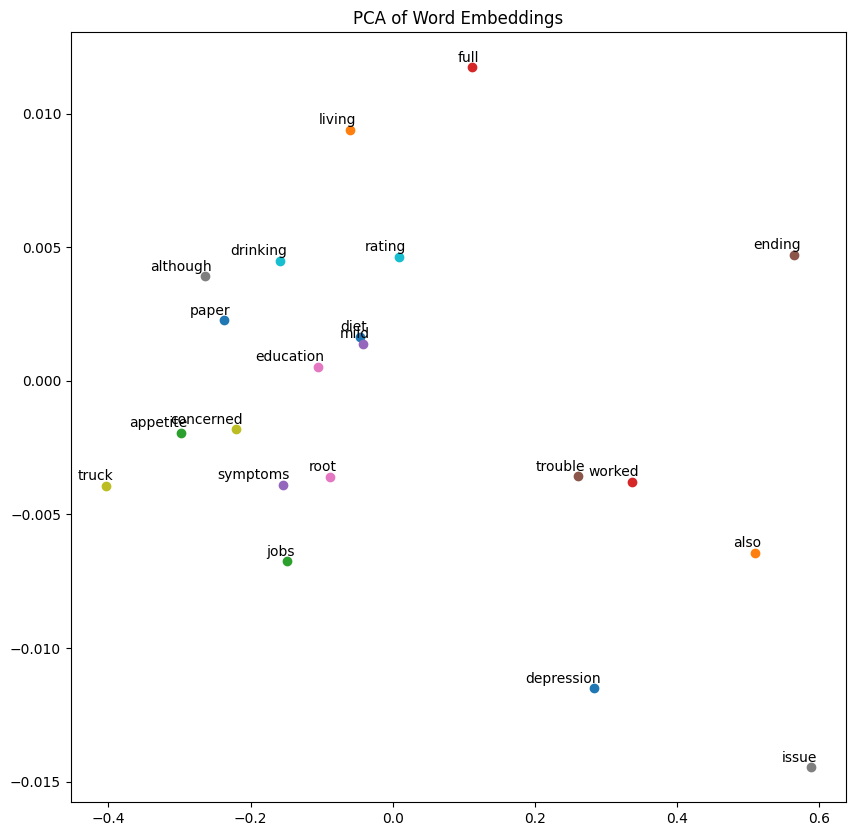

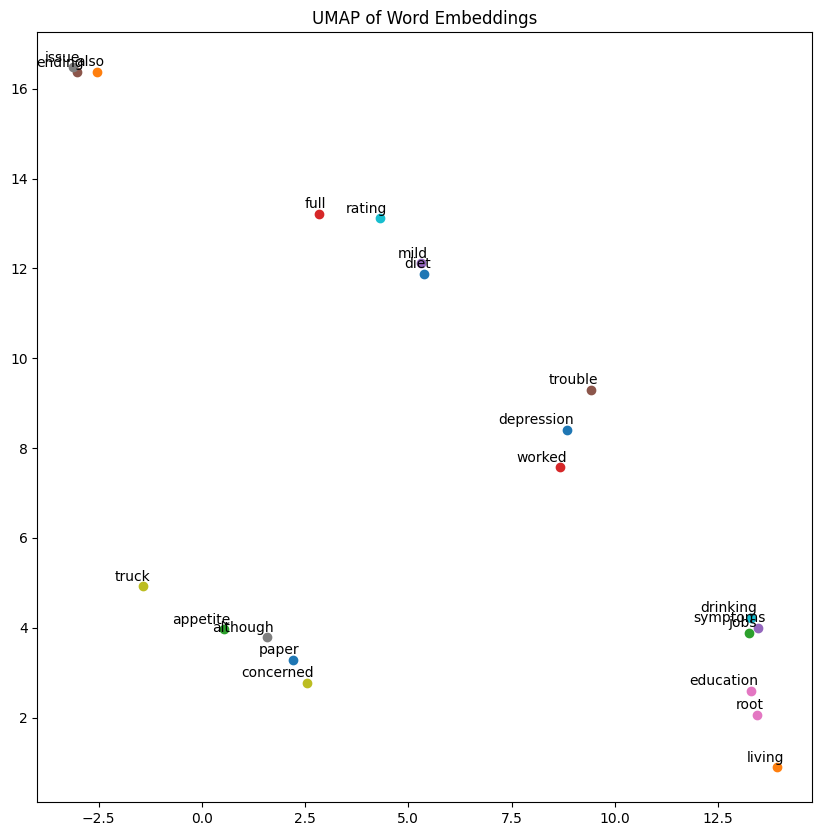

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
import pandas as pd

# PCA
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(X)

# UMAP
umap = UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
word_vectors_umap = umap.fit_transform(X)

# Function to plot
def plot_embeddings(embeddings, words, title="Word Embeddings"):
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(embeddings[i, 0], embeddings[i, 1])
        plt.annotate(word, xy=(embeddings[i, 0], embeddings[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
    plt.title(title)
    plt.show()

# Assuming 'words' is a list of words corresponding to your vectors
plot_embeddings(word_vectors_pca, words, title="PCA of Word Embeddings")
plot_embeddings(word_vectors_umap, words, title="UMAP of Word Embeddings")

##tft-idf with logistic regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
df = pd.read_csv("participant_transcript_data_with_participant_column.csv")

# Split the data into features and target label
texts = df['Participant_Text']  # This should contain the participant text
labels = df['PHQ8_Binary']  # This should contain the binary labels for depression

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create a TF-IDF Vectorizer and Logistic Regression pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# To make a prediction on new text:
def predict_new_text(text):
    return pipeline.predict([text])[0]

# Example usage:
new_text = "I've been feeling so down lately and nothing seems to lift my mood."
predicted_class = predict_new_text(new_text)
print(f"The predicted class for the new text is: {predicted_class}")


              precision    recall  f1-score   support

         0.0       0.53      0.89      0.67         9
         1.0       0.00      0.00      0.00         7

    accuracy                           0.50        16
   macro avg       0.27      0.44      0.33        16
weighted avg       0.30      0.50      0.38        16

Accuracy: 0.5
The predicted class for the new text is: 0.0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
df = pd.read_csv("participant_transcript_data_with_participant_column.csv")

# Split the data into features and target label
texts = df['Participant_Text']  # This should contain the participant text
labels = df['PHQ8_Binary']  # This should contain the binary labels for depression

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Create a TF-IDF Vectorizer and Multinomial Naive Bayes pipeline
model = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# To make a prediction on new text:
def predict_new_text(text):
    return model.predict([text])[0]

# Example usage:
new_text = "I've been feeling so down lately and nothing seems to lift my mood."
predicted_class = predict_new_text(new_text)
print(f"The predicted class for the new text is: {predicted_class}")


              precision    recall  f1-score   support

         0.0       0.56      1.00      0.72         9
         1.0       0.00      0.00      0.00         7

    accuracy                           0.56        16
   macro avg       0.28      0.50      0.36        16
weighted avg       0.32      0.56      0.40        16

Accuracy: 0.5625
The predicted class for the new text is: 0.0


##DistilBERT

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Check if a GPU is available and set PyTorch to use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
df = pd.read_csv("participant_transcript_data_with_participant_column.csv")
transcripts = df['Participant_Text'].tolist()
labels = df['PHQ8_Binary'].tolist()

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(transcripts, labels, test_size=0.2, random_state=42)

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenization and input formatting
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert to torch tensors
train_seq = torch.tensor(train_encodings['input_ids'])
train_mask = torch.tensor(train_encodings['attention_mask'])
train_y = torch.tensor(train_labels)

val_seq = torch.tensor(val_encodings['input_ids'])
val_mask = torch.tensor(val_encodings['attention_mask'])
val_y = torch.tensor(val_labels)

# DataLoader
batch_size = 16

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = torch.utils.data.SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Load the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss().to(device)  # Use CrossEntropyLoss

# Training Loop
for epoch in range(5):  # loop over the dataset multiple times
    model.train()
    total_loss = 0  # Initialize total loss for the epoch
    for batch in train_loader:
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)  # No need to change the label format

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        loss = loss_fn(outputs.logits, batch_labels)  # Adjust for CrossEntropyLoss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print loss every step
        print(f"Step loss: {loss.item()}")
    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1} average loss: {average_loss}')

# Validation Loop
model.eval()
val_preds, val_labels = [], []

for batch in val_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    val_preds.append(logits)
    val_labels.append(label_ids)

# Flatten the predictions and labels
val_preds = np.concatenate(val_preds, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Convert logits to predictions
preds = np.argmax(val_preds, axis=1)

# Evaluation
print(classification_report(val_labels, preds))

# Save the model and the tokenizer
model.save_pretrained("distilbert_finetuned")
tokenizer.save_pretrained("distilbert_finetuned")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step loss: 0.7005903720855713
Step loss: 0.6847934722900391
Step loss: 0.7005122900009155
Step loss: 0.6564649343490601
Epoch 1 average loss: 0.6855902671813965
Step loss: 0.7107924818992615
Step loss: 0.6779937744140625
Step loss: 0.6873868703842163
Step loss: 0.6288309097290039
Epoch 2 average loss: 0.676251009106636
Step loss: 0.6622775197029114
Step loss: 0.7405004501342773
Step loss: 0.6331236958503723
Step loss: 0.6704699993133545
Epoch 3 average loss: 0.6765929162502289
Step loss: 0.6269130706787109
Step loss: 0.6586617827415466
Step loss: 0.7229801416397095
Step loss: 0.7360997796058655
Epoch 4 average loss: 0.6861636936664581
Step loss: 0.5947759747505188
Step loss: 0.650964081287384
Step loss: 0.6587300300598145
Step loss: 0.7856976985931396
Epoch 5 average loss: 0.6725419461727142
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.72         9
         1.0       0.00      0.00      0.00         7

    accuracy                     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('distilbert_finetuned/tokenizer_config.json',
 'distilbert_finetuned/special_tokens_map.json',
 'distilbert_finetuned/vocab.txt',
 'distilbert_finetuned/added_tokens.json')

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Load the tokenizer and model from saved path
model_path = "distilbert_finetuned"
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.to(device)

# Function to predict the class label
def predict(text, tokenizer, model):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

    return predictions.cpu().numpy()[0]

# Example text
text = "I've been feeling quite down lately, I don't find joy in things I used to love."

# Predict
class_label = predict(text, tokenizer, model)
print(f"The predicted class for the new text is: {class_label}")


The predicted class for the new text is: 0
